<a href="https://colab.research.google.com/github/malacosteus/MIPT/blob/main/ML/lab1_main_notebook_finv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import tqdm


# Framework



```
# This is formatted as code
```

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
import numpy as np

"""**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments."""

class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input`.
        
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        
        # The easiest case:
        
        # self.gradInput = gradOutput 
        # return self.gradInput
        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

"""# Sequential container

**Define** a forward and backward pass procedures.
"""

class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.inp_save = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        # Your code goes here. ################################################

        tmp_y = input
        self.inp_save.append(tmp_y)

        for md in self.modules:
            tmp_y = md.forward(tmp_y)
            self.inp_save.append(tmp_y)

        self.output = tmp_y

        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input, g_1)   
             
             
        !!!
                
        To ech module you need to provide the input, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass) 
        and NOT `input` to this Sequential module. 
        
        !!!
        
        """
        # Your code goes here. ################################################

        tmp_grad = gradOutput

        # let's reverse our data for backward pass
        back_pass = zip(self.inp_save[-2::-1], self.modules[::-1])

        for p_inp, md in back_pass:
            tmp_grad = md.backward(p_inp, tmp_grad)

        self.gradInput = tmp_grad

        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

"""# Layers

## 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**
"""

class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = ...

        self.output = np.dot(input, self.W.T) + self.b

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradInput = ...

        self.gradInput = np.dot(gradOutput, self.W)

        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...

        self.gradW = np.dot(gradOutput.T, input)
        self.gradb = np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

"""## 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.
"""

class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        
        # Your code goes here. ################################################

        term1 = np.exp(self.output)
        self.output = term1 / np.sum(np.exp(self.output), axis=1).reshape(term1.shape[0], -1)

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        gradOutput_slf = gradOutput * self.output
        self.gradInput = -self.output * gradOutput_slf.sum(axis=1).reshape(-1,1) + gradOutput_slf

        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

"""## 3. LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.
"""

class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        
        # Your code goes here. ################################################

        self.exp_inp = np.exp(input)
        self.exp_inp_sum = np.sum(self.exp_inp, axis=1)
        self.output = (input - np.log(self.exp_inp_sum).reshape(input.shape[0], -1))

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        one_grad = (self.exp_inp / self.exp_inp_sum.reshape(self.exp_inp.shape[0], -1))
        gradient = np.einsum("ij,k->ikj", one_grad, np.ones(self.exp_inp.shape[1]))
        self.gradInput = gradOutput - np.einsum("bm,bmk->bk", gradOutput, gradient)

        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

"""## 4. Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance: 
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance. 

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.
"""

class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None 
        self.moving_variance = None
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please

        if self.moving_mean is None:
            self.moving_mean = 0
        if self.moving_variance is None:
            self.moving_variance = 0

        self.b_mn = self.moving_mean
        self.b_vr = self.moving_variance
        if self.training:
            self.b_mn = np.mean(input, axis=0)
            self.b_vr = np.var(input, axis=0)

            term1 = self.b_mn * (1 - self.alpha)
            self.moving_mean = self.moving_mean * self.alpha + term1

            term1 = self.b_vr * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + term1

        self.b_vr = 1 / np.sqrt(self.b_vr + self.EPS)

        self.output = (input - self.b_mn) * self.b_vr

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        shp1 = input.shape[0]
        tmp = shp1 * gradOutput - np.sum(gradOutput, axis=0) -  self.output * np.sum(gradOutput * self.output, axis=0)
        self.gradInput = tmp * self.b_vr / shp1

        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

"""Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**
"""

class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        # Your code goes here. ################################################

        self.output = input
        if self.training:
            self.mask = np.random.binomial(1, 1 - self.p, input.shape) / (1 - self.p)
            self.output = self.output * self.mask

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = gradOutput
        if self.training:
            self.gradInput = self.gradInput * self.mask

        return self.gradInput

    def __repr__(self):
        return "Dropout"

"""# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):
"""

class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

"""## 6. Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope. 
"""

class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        # Your code goes here. ################################################

        self.output = np.maximum(input + np.minimum(self.slope * input, 0), np.minimum(self.slope * input, 0))

        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        msk1 = input >= 0
        msk2 = input < 0
        self.gradInput = gradOutput * (msk1 + self.slope * msk2) 

        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

"""## 7. ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.
"""

class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def updateOutput(self, input):
        # Your code goes here. ################################################

        self.output = np.maximum(input + self.alpha * (np.exp(np.minimum(input, 0)) - 1), \
                                 self.alpha * (np.exp(np.minimum(input, 0)) - 1)) 

        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        msk1 = input >= 0
        msk2 = input < 0

        self.gradInput =  gradOutput * (msk1 + msk2 * self.alpha + self.alpha * np.exp(np.minimum(input, 0)) - 1)

        return self.gradInput
    
    def __repr__(self):
        return "ELU"

"""## 8. SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.
"""

class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        # Your code goes here. ################################################

        self.output = np.log(1 + np.exp(input))

        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput =  gradOutput * np.exp(input) / (1 + np.exp(input))

        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"

"""# Criterions

Criterions are used to score the models answers.
"""

class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

"""The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**
"""

class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

"""## 9. Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula, 
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**


"""

class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target): 
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        
        # Your code goes here. ################################################

        self.output = (-1 / input.shape[0]) * np.sum(target * np.log(input_clamp)) 

        return self.output

    def updateGradInput(self, input, target):
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
                
        # Your code goes here. ################################################

        self.gradInput = (-1 / (input_clamp * input.shape[0])) * target

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

"""## 10. Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().
"""

class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        # Your code goes here. ################################################

        self.output = (-1 / input.shape[0]) * np.sum(target * input) 

        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################

        self.gradInput = (-1 / input.shape[0]) * target

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

"""# Optimizers

### SGD optimizer with momentum
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate` and `momentum`)
- `state` - dict with optimizator state (used to save accumulated gradients)
"""

def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1

"""## 11. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$
"""

def adam_optimizer(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()

    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))

            # <YOUR CODE> #######################################
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            #np.add(... , out=var_first_moment)
            #np.add(... , out=var_second_moment)
            #current_var -= ...

            beta1 = config['beta1']
            beta2 = config['beta2']
            term1 = current_grad * (1 - beta1)
            term2 = (current_grad ** 2) * (1 - beta2) 

            np.add(beta1 * var_first_moment,  term1, out=var_first_moment)
            np.add(beta2 * var_second_moment, term2, out=var_second_moment)
            current_var -= lr_t * var_first_moment / (np.sqrt(var_second_moment) + config['epsilon'])

            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1

"""# Layers for advanced track homework
You **don't need** to implement it if you are working on `homework_main-basic.ipynb`

## 12. Conv2d [Advanced]
- input:   **`batch_size x in_channels x h x w`**
- output: **`batch_size x out_channels x h x w`**

You should implement something like pytorch `Conv2d` layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.

Practical notes:
- While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch) implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory. So **don't use** `scipy.signal.convolve` since it implements [convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution) in terms of signal processing.
- It may be convenient to use `skimage.util.pad` for zero-padding.
- It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension
- Having troubles with understanding how to implement the layer? 
 - Check the last year video of lecture 3 (starting from ~1:14:20)
 - May the google be with you
"""

import scipy as sp
import scipy.signal
import skimage

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2d, self).__init__()
        assert kernel_size % 2 == 1, kernel_size
       
        stdv = 1./np.sqrt(in_channels)
        self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size))
        self.b = np.random.uniform(-stdv, stdv, size=(out_channels,))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        pad_size = self.kernel_size // 2
        # YOUR CODE ##############################
        # 1. zero-pad the input array
        # 2. compute convolution using scipy.signal.correlate(... , mode='valid')
        # 3. add bias value
        
        # self.output = ...
        
        output_shape = (input.shape[0], self.out_channels, input.shape[2], input.shape[3])
        self.output = np.zeros(output_shape)

        pd_width = ([0]*2, [0]*2, [pad_size]*2, [pad_size]*2)
        pddng = np.pad(input, pd_width)

        for el in range(input.shape[0]):
            for o in range(self.out_channels):
                self.output[el][o] = self.b[o]
                self.output[el][o] = self.output[el][o] + \
                                     scipy.signal.correlate(pddng[el], self.W[o], mode='valid')[0]

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # YOUR CODE ##############################
        # 1. zero-pad the gradOutput
        # 2. compute 'self.gradInput' value using scipy.signal.correlate(... , mode='valid')
        
        # self.gradInput = ...

        self.gradInput = np.zeros(input.shape)

        pd_width = ([0]*2, [0]*2, [pad_size]*2, [pad_size]*2)
        pddng = np.pad(gradOutput, pd_width)
    
        for el in range(input.shape[0]):
            for i in range(self.in_channels):
                self.gradInput[el][i] = scipy.signal.correlate(pddng[el],
                                                               (self.W[:, :, ::-1, ::-1])[:, i],
                                                               mode='valid')[0]

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # YOUR CODE #############
        # 1. zero-pad the input
        # 2. compute 'self.gradW' using scipy.signal.correlate(... , mode='valid')
        # 3. compute 'self.gradb' - formulas like in Linear of ChannelwiseScaling layers
        
        # self.gradW = ...
        # self.gradb = ...

        self.gradb = np.sum(gradOutput, axis=(0, 2, 3))
        self.gradW = np.zeros(self.W.shape)

        pd_width = ([0]*2, [0]*2, [pad_size]*2, [pad_size]*2)
        pddng = np.pad(input, pd_width)

        for i in range(self.in_channels):
            for o in range(self.out_channels):
                self.gradW[o][i] = scipy.signal.correlate(pddng[:, i], gradOutput[:, o], mode='valid')[0]

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Conv2d %d -> %d' %(s[1],s[0])
        return q

"""## 13. MaxPool2d [Advanced]
- input:   **`batch_size x n_input_channels x h x w`**
- output: **`batch_size x n_output_channels x h // kern_size x w // kern_size`**

You are to implement simplified version of pytorch `MaxPool2d` layer with stride = kernel_size. Please note, that it's not a common case that stride = kernel_size: in AlexNet and ResNet kernel_size for max-pooling was set to 3, while stride was set to 2. We introduce this restriction to make implementation simplier.

Practical notes:
- During forward pass what you need to do is just to reshape the input tensor to `[n, c, h / kern_size, kern_size, w / kern_size, kern_size]`, swap two axes and take maximums over the last two dimensions. Reshape + axes swap is sometimes called space-to-batch transform.
- During backward pass you need to place the gradients in positions of maximal values taken during the forward pass
- In real frameworks the indices of maximums are stored in memory during the forward pass. It is cheaper than to keep the layer input in memory and recompute the maximums.
"""

class MaxPool2d(Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.gradInput = None
                    
    def updateOutput(self, input):
        input_h, input_w = input.shape[-2:]
        # your may remove these asserts and implement MaxPool2d with padding
        assert input_h % self.kernel_size == 0  
        assert input_w % self.kernel_size == 0
        
        # YOUR CODE #############################
        # self.output = ...
        # self.max_indices = ...

        inp_new_shape = (input.shape[0], input.shape[1], int(input_h / self.kernel_size),\
                         self.kernel_size, int(input_w / self.kernel_size), self.kernel_size)
        input = np.swapaxes(input.reshape(inp_new_shape), 3, 4)

        self.output = np.max(input, axis=(4, 5))
        self.max_indices = (input - self.output[:, :, :, :, None, None]) == 0

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # YOUR CODE #############################
        # self.gradInput = ...

        self.gradInput = gradOutput[:, :, :, :, None, None] * self.max_indices
        self.gradInput = np.swapaxes(self.gradInput, 3, 4).reshape(input.shape)

        return self.gradInput
    
    def __repr__(self):
        q = 'MaxPool2d, kern %d, stride %d' %(self.kernel_size, self.kernel_size)
        return q

"""### Flatten layer
Just reshapes inputs and gradients. It's usually used as proxy layer between Conv2d and Linear.
"""

class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()
    
    def updateOutput(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        return "Flatten"

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

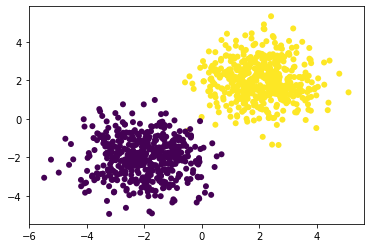

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

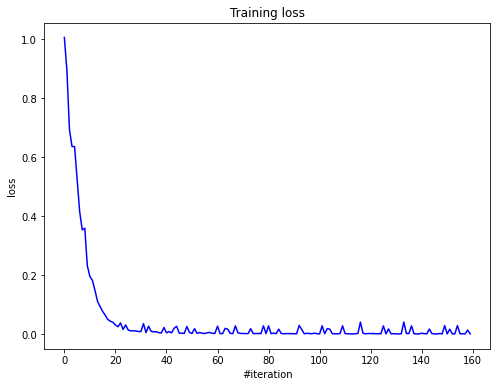

Current loss: 0.000998


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
import sys
import os
import time

import numpy as np

__doc__="""taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""

def load_dataset(flatten=False):
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return (data / np.float32(256)).squeeze()

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])


    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

# Let's flatten images!
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

In [ ]:
inp_shape = X_train.shape[1]

In [ ]:
inp_shape

784

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
def net_diff_act(act):
    net = Sequential()
    net.add(Linear(inp_shape, 230))
    net.add(act())
    net.add(Linear(230, 10))
    net.add(LogSoftMax())
    return net


def model_train(X, Y, X_val, y_val, batch_size, net, criterion, optimizer, optimizer_config, n_epoch):
    loss_val = []
    optimizer_state = dict()

    for i in tqdm(range(n_epoch)):
        net.train()
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            net.zeroGradParameters()

            predictions = net.forward(x_batch)

            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)

            net.backward(x_batch, dp)
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)      

        # check val set
        net.evaluate()
        preds = net.forward(X_val)
        loss_tmp = criterion.forward(preds, y_val)
        loss_val.append(loss_tmp)
    return loss_val

In [ ]:
def plt1(labels, val_losses, prnt=True):
    plt.figure(figsize=(10, 10))

    plt.title("Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")

    for ls, lb in zip(val_losses, labels):
        plt.plot(ls, label=lb)

    plt.legend()
    plt.show()

    if prnt:
        for ls, lb in zip(val_losses, labels):
            print(f'Label: {lb}; Loss: {ls[-1]}')

In [ ]:
act_lst = [ReLU, ELU, LeakyReLU, SoftPlus]
losses_no_nrm = []

n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 5e-2, 'momentum': 0.9}

criterion = ClassNLLCriterion()
optimizer = sgd_momentum

labels_no_nrm = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]

for fnc in act_lst:
    net = net_diff_act(fnc)
    loss = model_train(X_train, y_train, X_val, y_val, batch_size, net, criterion, optimizer, optimizer_config, n_epoch)
    losses_no_nrm.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

**Normalization**

In [ ]:
def crt_nt_nrmlz(act):
    net = Sequential()
    net.add(Linear(inp_shape, 230))
    net.add(act())
    net.add(BatchNormalization(0.6))
    net.add(ChannelwiseScaling(230))
    net.add(Linear(230, 10))
    net.add(LogSoftMax())
    return net

In [ ]:
n_epoch = 10
batch_size = 512

criterion = ClassNLLCriterion()
optimizer = sgd_momentum
optimizer_config = {'learning_rate' : 5e-2, 'momentum': 0.9}

losses_nrm = []
labels_nrm = ["ReLU norm", "ELU norm", "LeakyReLU norm", "SoftPlus norm"]

for fnc in act_lst:
    net_norm = crt_nt_nrmlz(fnc)
    loss = model_train(X_train, y_train, X_val, y_val, batch_size, net_norm, criterion, optimizer, optimizer_config, n_epoch)
    losses_nrm.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

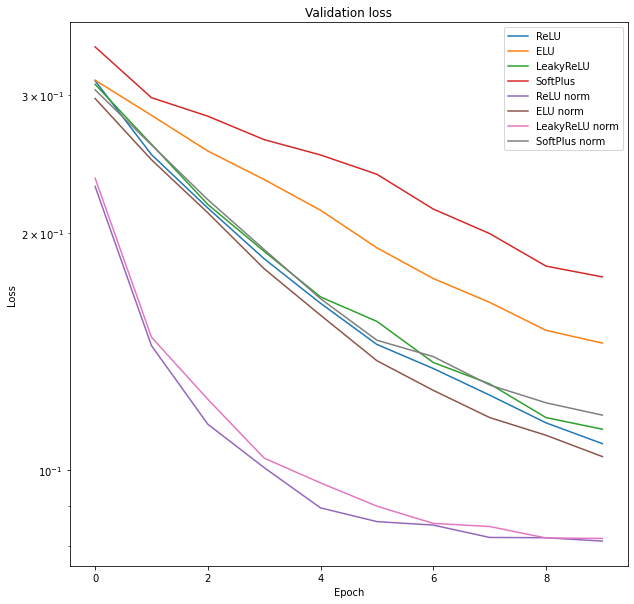

Label: ReLU; Loss: 0.10805360784055179
Label: ELU; Loss: 0.1450226412031831
Label: LeakyReLU; Loss: 0.11271866808357309
Label: SoftPlus; Loss: 0.17601387461888696
Label: ReLU norm; Loss: 0.08124392616781312
Label: ELU norm; Loss: 0.1040391424902641
Label: LeakyReLU norm; Loss: 0.08187714977590765
Label: SoftPlus norm; Loss: 0.1174561441457862


In [ ]:
plt1(labels_no_nrm + labels_nrm, losses_no_nrm + losses_nrm)

**We see that results are better with batch normaliztion**

In [ ]:
lr = 0.05

n_epoch = 10
batch_size = 512

net_sgd = net_diff_act(ReLU)

criterion = ClassNLLCriterion()
optimizer = sgd_momentum
optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}

losses = []
labels = [f"SGD with learning_rate {lr}"]

loss = model_train(X_train, y_train, X_val, y_val, batch_size, net_sgd, criterion, optimizer, optimizer_config, n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

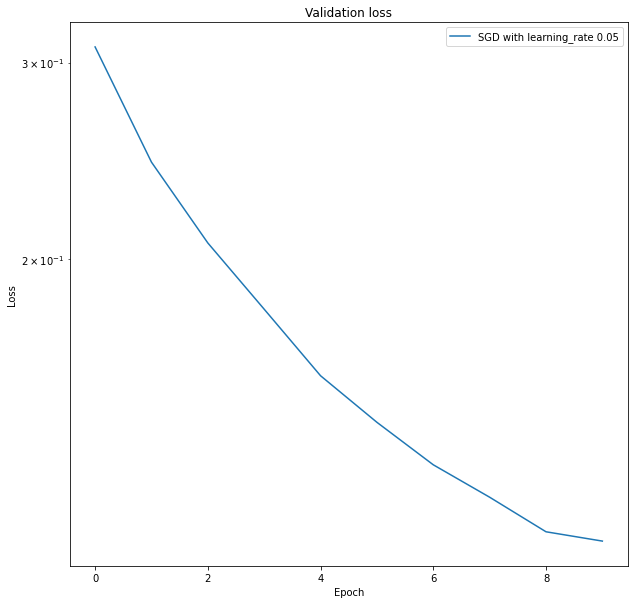

Label: SGD with learning_rate 0.05; Loss: 0.11155653357767106


In [ ]:
plt1(labels, [loss])

In [ ]:
lr = 1e-3
eps = 1e-8
beta1 = 0.5
beta2 = 0.7
n_epoch = 10
batch_size = 512

criterion = ClassNLLCriterion()
optimizer = adam_optimizer
optimizer_config = {'learning_rate' : lr, 'beta1': beta1, 'beta2':beta2, 'epsilon':eps}

losses = []

label = f"Adam with beta1={beta1}, beta2={beta1}, init learning rate = {lr}"

net_adam = net_diff_act(ReLU)
optimizer_config = {'learning_rate' : lr, 'beta1': beta1, 'beta2':beta2, 'epsilon':eps}

loss = model_train(X_train, y_train, X_val, y_val, batch_size, net_adam, criterion, optimizer, optimizer_config, n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

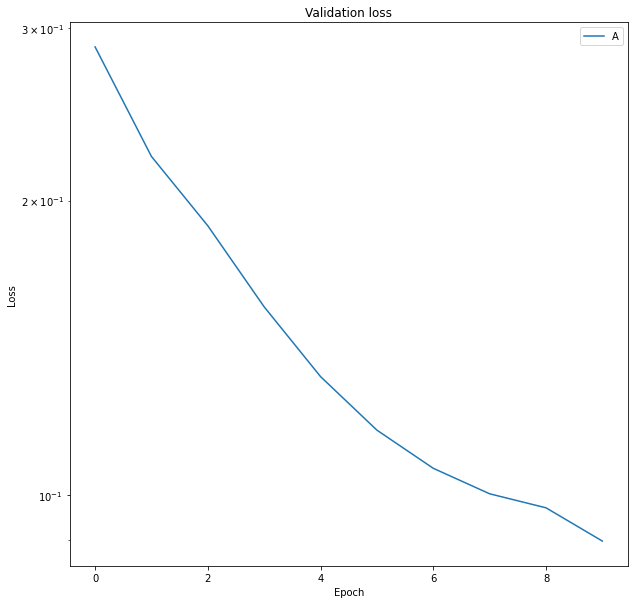

Label: A; Loss: 0.08975044158413642


In [ ]:
plt1(label, [loss])

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Your answer goes here.**
ReLU and Leaky ReLU activation functions have shown best reults in our tetcases. And computation time insignificantly differs in comparison to other activation functions for our dataset

From our experiments and figures it's clearly seen that can BatchNormalization significantly improves performance.

We achieve best performance with Adam optimizer. Finding right hyperparameters for our optimizers may significantly affect performance of model.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(inp_shape, 230))
net.add(Dropout(p=0.15))
net.add(ReLU())
net.add(BatchNormalization(0.6))
net.add(ChannelwiseScaling(230))
net.add(Linear(230, 10))
net.add(Dropout(p=0.15))
net.add(LogSoftMax())

In [ ]:
n_epoch = 10
batch_size = 512

criterion = ClassNLLCriterion()
optimizer = adam_optimizer
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.3, 'beta2':0.7, 'epsilon':1e-8}

_ = model_train(X_train, y_train, X_val, y_val, batch_size, net, criterion, optimizer, optimizer_config, n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
net.evaluate()
preds = np.argmax(net.forward(X_test), axis = 1)
print(accuracy_score(preds,np.argmax(y_test, axis=1)))

0.9783


**Greate accuracy**

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.
import torch

best = torch.nn.Sequential(
    torch.nn.Flatten(),  
    torch.nn.Linear(inp_shape, 230),
    torch.nn.Dropout(0.15),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(230, 0.6),
    torch.nn.Linear(230, 10),
    torch.nn.Dropout(0.15),
    torch.nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(best.parameters(), lr = 1e-3)

In [ ]:
def torh_train(n_epoch, X, Y, batch_size, net, criterion, optimizer):
    net.train()
    for i in tqdm(range(n_epoch)):
        for x, y in get_batches((X, Y), batch_size):
            x = torch.tensor(x)
            y = torch.tensor(y)

            prd = net.forward(x)

            loss = criterion(prd, torch.argmax(y, axis=1))
            loss.backward()
            optimizer.step() 
            optimizer.zero_grad()
    return 

In [ ]:
n_epoch = 10
batch_size = 512
_ = torh_train(n_epoch, X_train, y_train, batch_size, best, torch.nn.functional.nll_loss, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Your answer goes here. ################################################
best.eval()
prds = best.forward(torch.tensor(X_test)).detach().numpy()
print(accuracy_score(np.argmax(prds, axis = 1), np.argmax(y_test, axis=1)))

0.9775


Our code achieves similar accuracy as pytorch